In [185]:
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score

In [3]:
#conn = sqlite3.connect(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\mimic.db')

In [159]:
admissions = pd.read_csv(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\mimic-iii\ADMISSIONS.csv')

In [189]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [6]:
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [7]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  58976 non-null int64
SUBJECT_ID              58976 non-null int64
HADM_ID                 58976 non-null int64
ADMITTIME               58976 non-null object
DISCHTIME               58976 non-null object
DEATHTIME               5854 non-null object
ADMISSION_TYPE          58976 non-null object
ADMISSION_LOCATION      58976 non-null object
DISCHARGE_LOCATION      58976 non-null object
INSURANCE               58976 non-null object
LANGUAGE                33644 non-null object
RELIGION                58518 non-null object
MARITAL_STATUS          48848 non-null object
ETHNICITY               58976 non-null object
EDREGTIME               30877 non-null object
EDOUTTIME               30877 non-null object
DIAGNOSIS               58951 non-null object
HOSPITAL_EXPIRE_FLAG    58976 non-null int64
HAS_CHARTEVENTS_DATA    58976 non-null int64
dtypes: int64(5), objec

In [161]:
admissions['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [162]:
#Removing new borns
admissions = admissions.loc[admissions.ADMISSION_TYPE != 'NEWBORN']

In [163]:
#Rows with NEWBORN ADMISSION_TYPE are removed
admissions['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [11]:
#Saving the dead patients for later usage
deadPatients = admissions.loc[admissions.DEATHTIME.notnull()]
print("Number of patients died:", len(deadPatients))

Number of patients died: 5792


In [12]:
#Removing pateints who are dead as they cant be readmitted
admissions = admissions.loc[admissions.DEATHTIME.isnull()]

In [13]:
#Checking whether the dead patients are removed
admissions.loc[admissions.DEATHTIME.notnull()]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA


In [14]:
# Checking if there are any missing dates in the data
print('Missing admission dates:', admissions.ADMITTIME.isnull().sum())
print('Missing discharge dates:', admissions.DISCHTIME.isnull().sum())

Missing admission dates: 0
Missing discharge dates: 0


In [15]:
#convert the dates to proper format
admissions.ADMITTIME = pd.to_datetime(admissions.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DISCHTIME = pd.to_datetime(admissions.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DEATHTIME = pd.to_datetime(admissions.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [16]:
#Date and Time columns have been changed
admissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45321 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  45321 non-null int64
SUBJECT_ID              45321 non-null int64
HADM_ID                 45321 non-null int64
ADMITTIME               45321 non-null datetime64[ns]
DISCHTIME               45321 non-null datetime64[ns]
DEATHTIME               0 non-null datetime64[ns]
ADMISSION_TYPE          45321 non-null object
ADMISSION_LOCATION      45321 non-null object
DISCHARGE_LOCATION      45321 non-null object
INSURANCE               45321 non-null object
LANGUAGE                30317 non-null object
RELIGION                44966 non-null object
MARITAL_STATUS          43346 non-null object
ETHNICITY               45321 non-null object
EDREGTIME               26792 non-null object
EDOUTTIME               26792 non-null object
DIAGNOSIS               45297 non-null object
HOSPITAL_EXPIRE_FLAG    45321 non-null int64
HAS_CHARTEVENTS_DATA    45321 non-null int64
dt

In [17]:
#Sorting the data by subject_ID and admission date to make sure we do not mess with different patients data
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME'])
#When we reset the index, the old index is added as a column, and a new sequential index is used. 
#Use the 'drop' parameter to avoid the old index being added as a column
admissions = admissions.reset_index(drop = True)

In [18]:
#single patients data looks like this now
admissions.loc[admissions.SUBJECT_ID == 23]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
12,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
13,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1


In [19]:
#Add the next admission date and admission type for each subject using groupby 
#as the dates of all the patients are different. I am shifting the data by 1 
admissions['READMITTIME'] = admissions.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
admissions['READMISSION_TYPE'] = admissions.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [20]:
#Replacing rows of 'elective' admissions with NaT and NaN as we are only looking into emergency cases
temp = admissions.READMISSION_TYPE == 'ELECTIVE'
admissions.loc[temp,'READMITTIME'] = pd.NaT
admissions.loc[temp,'READMISSION_TYPE'] = np.NaN

In [21]:
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME'])
#As I deleted the Elective type and time of admit, I am replacing them with any emergencies present later on
admissions[['READMITTIME','READMISSION_TYPE']] = admissions.groupby(['SUBJECT_ID'])[['READMITTIME','READMISSION_TYPE']].fillna(method = 'bfill')

In [22]:
#Calculating the number of days until the next admission
admissions['DAYS_NEXT_ADMIT'] = (admissions.READMITTIME - admissions.DISCHTIME).dt.total_seconds()/(24*60*60)

###############################################################################################################################

In [24]:
diagnoses = pd.read_csv(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\mimic-iii\DIAGNOSES_ICD.csv')

In [25]:
print('Number of unique ICD9 codes:',len(diagnoses['ICD9_CODE'].value_counts()))

Number of unique ICD9 codes: 6984


In [26]:
# Converting E and V codes to numeric ICD9 codes and also taking first the digits of all codes
diagnoses['symptoms'] = diagnoses['ICD9_CODE']
diagnoses['symptoms'] = diagnoses['symptoms'][~diagnoses['symptoms'].str.contains("[a-zA-Z]").fillna(False)]
diagnoses['symptoms'].fillna(value='999', inplace=True)
diagnoses['symptoms'] = diagnoses['symptoms'].str.slice(start=0, stop=3, step=1)
diagnoses[['symptoms']] = diagnoses[['symptoms']].apply(pd.to_numeric)

In [27]:
#ICD9 categories
ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),(390, 460), (460, 520),
               (520, 580), (580, 630), (630, 680), (680, 710),(710, 740), (740, 760), (760, 780), (780, 800),
               (800, 1000)]

#Mapping the categories
recode = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',4: 'mental', 5: 'nervous', 6: 'circulatory', 
          7: 'respiratory',8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 12: 'musculoskeletal pain', 
          13: 'congenital', 14: 'perinatal', 15: 'misc',16: 'injury'}

for num, cat_range in enumerate(ranges):
    diagnoses['symptoms'] = np.where(diagnoses['symptoms'].between(cat_range[0],cat_range[1]),
            num, diagnoses['symptoms'])

In [28]:
diagnoses.head(3)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,symptoms
0,1297,109,172335,1.0,40301,6
1,1298,109,172335,2.0,486,7
2,1299,109,172335,3.0,58281,9


In [29]:
#Convert integer to category name using diag_dict
diagnoses['symptoms'] = diagnoses['symptoms']
diagnoses['symptoms'] = diagnoses['symptoms'].replace(recode)

In [30]:
# Create list of diagnoses for each admission
hadm_list = diagnoses.groupby('HADM_ID')['symptoms'].apply(list).reset_index()
hadm_list.head(3)

,HADM_ID,symptoms
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."


In [31]:
#See endocrine is repeated 5 times for a single patient
hadm_list['symptoms'].loc[0]

['endocrine',
 'nervous',
 'genitourinary',
 'digestive',
 'injury',
 'endocrine',
 'digestive',
 'circulatory',
 'endocrine',
 'circulatory',
 'genitourinary',
 'endocrine',
 'nervous',
 'endocrine',
 'skin',
 'injury']

In [32]:
#Now converting the symptoms into dummies and storing the count of each patients same symptoms numbers intact
dummies = pd.get_dummies(hadm_list['symptoms'].apply(pd.Series).stack()).sum(level=0)

In [33]:
#joining HADM_ID with the symptoms matrix
dummies = dummies.join(hadm_list['HADM_ID'], how="outer")

In [34]:
#Joining admission and Diagnosis codes
adm_diag = admissions.merge(dummies, how='inner', on='HADM_ID')
adm_diag.head(3)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,injury,mental,misc,musculoskeletal pain,neoplasms,nervous,perinatal,pregnancy,respiratory,skin
0,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,0,0,1,0,0,0,0,0,0,1
1,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,2,0,2,0,0,0,0,0,0,0
2,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,2,0,0,0,0,0,0,0,0,0


###############################################################################################################################

In [35]:
notes = pd.read_csv(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\mimic-iii\NOTEEVENTS.csv')

C:\Users\samsu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
notes

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...
...,...,...,...,...,...,...,...,...,...,...,...
2083175,2070657,31097,115637.0,2132-01-21,2132-01-21 03:27:00,2132-01-21 03:38:00,Nursing/other,Report,17581.0,NaN,NPN\n\n\n#1 Infant remains in RA with O2 sats...
2083176,2070658,31097,115637.0,2132-01-21,2132-01-21 09:50:00,2132-01-21 09:53:00,Nursing/other,Report,19211.0,NaN,"Neonatology\nDOL #5, CGA 36 weeks.\n\nCVR: Con..."
2083177,2070659,31097,115637.0,2132-01-21,2132-01-21 16:42:00,2132-01-21 16:44:00,Nursing/other,Report,20104.0,NaN,Family Meeting Note\nFamily meeting held with ...
2083178,2070660,31097,115637.0,2132-01-21,2132-01-21 18:05:00,2132-01-21 18:16:00,Nursing/other,Report,16023.0,NaN,NPN 1800\n\n\n#1 Resp: [**Known lastname 2243*...


In [37]:
notes['CATEGORY'].value_counts()

Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: CATEGORY, dtype: int64

In [38]:
notes.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

In [40]:
notes = notes[~notes['HADM_ID'].isin(deadPatients['HADM_ID'])]

In [41]:
#Concatenating different notes of a same person as one note based on CHARTDATE and CHARTTIME
#Convert CHARTDATE and CHARTTIME to proper date format
notes.CHARTDATE = pd.to_datetime(notes.CHARTDATE, format = '%Y-%m-%d', errors = 'coerce')
notes.CHARTTIME = pd.to_datetime(notes.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

notes = notes.sort_values(['SUBJECT_ID','CHARTDATE','CHARTTIME'])
notes = notes.reset_index(drop = True)

#Create a new dataframe as we only need these 2 columns
concat_notes = notes[['SUBJECT_ID', 'TEXT']].copy()

#Concatenating by each subject
concat_notes = concat_notes.groupby('SUBJECT_ID')['TEXT'].agg(' '.join).reset_index()
concat_notes.rename(columns={"TEXT":"TEXT_CONCAT"}, inplace=True)

C:\Users\samsu\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
#Using left join as we already preprocessed the admissions and diagnoses
adm_diag_notes = pd.merge(adm_diag[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','READMITTIME','READMISSION_TYPE',
                          'DEATHTIME','blood', 'circulatory','congenital', 'digestive', 'endocrine', 'genitourinary',
                          'infectious','injury', 'mental', 'misc', 'musculoskeletal pain', 'neoplasms','nervous', 
                          'perinatal', 'pregnancy', 'respiratory', 'skin']], 
                concat_notes, on = ['SUBJECT_ID'], how = 'left')

In [43]:
adm_diag_notes.head(2)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,READMITTIME,READMISSION_TYPE,DEATHTIME,blood,circulatory,...,mental,misc,musculoskeletal pain,neoplasms,nervous,perinatal,pregnancy,respiratory,skin,TEXT_CONCAT
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,NaN,NaT,0,4,...,0,1,0,0,0,0,0,0,1,[**2101-10-6**] 6:02 PM\n CHEST (PORTABLE AP) ...
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,NaN,NaT,0,0,...,0,2,0,0,0,0,0,0,0,[**2191-3-15**] 4:20 PM\n CHEST (PORTABLE AP) ...


In [44]:
#Creating a new binary column for readmission after and before 30 days
adm_diag_notes['READMISSION'] = (adm_diag_notes.DAYS_NEXT_ADMIT < 30).astype('int')

In [45]:
adm_diag_notes['READMISSION'].value_counts()

0    42772
1     2549
Name: READMISSION, dtype: int64

In [46]:
adm_diag_notes.loc[adm_diag_notes.SUBJECT_ID==23]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,READMITTIME,READMISSION_TYPE,DEATHTIME,blood,circulatory,...,misc,musculoskeletal pain,neoplasms,nervous,perinatal,pregnancy,respiratory,skin,TEXT_CONCAT,READMISSION
12,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,1501.016667,2157-10-18 19:34:00,EMERGENCY,NaT,0,4,...,0,0,0,1,0,0,0,0,[**2153-8-16**] 5:01 PM\n CHEST (PRE-OP PA & L...,0
13,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,NaT,NaN,NaT,0,2,...,0,0,1,1,1,0,0,0,[**2153-8-16**] 5:01 PM\n CHEST (PRE-OP PA & L...,0


In [47]:
#Copying the necessary columns in a new variable
notes_squashed_temp1 = adm_diag_notes[['SUBJECT_ID', 'TEXT_CONCAT', 'READMISSION','blood', 'circulatory','congenital', 
                                       'digestive', 'endocrine', 'genitourinary','infectious','injury', 'mental', 'misc',
                                       'musculoskeletal pain', 'neoplasms','nervous','perinatal','pregnancy', 'respiratory', 'skin']]

#Summation of all the values in output label and also with unique subjects 
notes_squashed_temp2 = notes_squashed_temp1.groupby('SUBJECT_ID')[['READMISSION']].sum().reset_index()

#Here if the value of output label is greater than 1, setting it to 1 otherwise 0
notes_squashed_temp2['READMISSION'] = (notes_squashed_temp2['READMISSION'] >= 1).astype(int)

#Dropping the old Readmission column so that we can merge both the temp datasets
notes_squashed_temp1.drop(columns=['READMISSION'], inplace=True)

#Removing extra obseravations of the same patients by keeping the first only 
notes_squashed_temp1.drop_duplicates(subset='SUBJECT_ID', keep='first', inplace=True)

#Checking the number of observations in bothe the datasets before merging, They should be equal
assert len(notes_squashed_temp2) == len(notes_squashed_temp1), 'Error'
print('Length of notes_squashed_temp1:', len(notes_squashed_temp1))
print('Length of notes_squashed_temp2:', len(notes_squashed_temp2))

adm_diag_notes_merged = pd.merge(notes_squashed_temp2,notes_squashed_temp1,on = ['SUBJECT_ID'], how = 'left')

Length of notes_squashed_temp1: 34560
Length of notes_squashed_temp2: 34560


C:\Users\samsu\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\samsu\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [48]:
adm_diag_notes_merged["READMISSION"].value_counts()

0    32621
1     1939
Name: READMISSION, dtype: int64

In [49]:
adm_diag_notes_merged

,SUBJECT_ID,READMISSION,TEXT_CONCAT,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,musculoskeletal pain,neoplasms,nervous,perinatal,pregnancy,respiratory,skin
0,3,0,[**2101-10-6**] 6:02 PM\n CHEST (PORTABLE AP) ...,0,4,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1
1,4,0,[**2191-3-15**] 4:20 PM\n CHEST (PORTABLE AP) ...,0,0,0,1,1,0,3,2,0,2,0,0,0,0,0,0,0
2,6,0,[**2175-5-25**] 10:52 AM\n CHEST (PRE-OP PA & ...,1,2,0,0,3,0,0,2,0,0,0,0,0,0,0,0,0
3,11,0,[**2178-4-16**] 5:01 AM\n MR HEAD W & W/O CONT...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,13,0,CCU ADMISSION NPN 1900-0700: LEFT MAIN\nHPI: I...,0,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34555,99985,0,Sinus rhythm. Normal ECG. Since the previous t...,1,0,0,1,2,0,1,3,0,1,0,1,0,0,0,3,0
34556,99991,0,[**2184-12-27**] 11:35 AM\n CHEST (PA & LAT) ...,0,2,0,5,2,1,1,3,0,2,1,0,0,0,0,0,0
34557,99992,0,[**2144-7-10**] 8:04 AM\n CHEST PORT. LINE PLA...,1,1,0,5,1,1,0,1,1,0,1,0,0,0,0,0,0
34558,99995,0,[**2147-1-10**] 8:15 AM\n CAROTID SERIES COMPL...,1,6,0,0,2,0,0,8,0,0,0,0,0,0,0,0,0


In [50]:
df = adm_diag_notes_merged.copy()

In [51]:
import nltk
from nltk import word_tokenize
import string
import re

def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT_CONCAT = df.TEXT_CONCAT.fillna(' ')
    df.TEXT_CONCAT =df.TEXT_CONCAT.str.replace('\n',' ')
    df.TEXT_CONCAT =df.TEXT_CONCAT.str.replace('\r',' ')
    return df

df = preprocess_text(df)

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

def clean_textmain(text):
    text = text.lower()
    text ="".join([char for char in text if char not in string.punctuation ])
    result = re.sub(r'[0-9]+','',text)
    tokens = re.split('\W+', result)
    words = [word for word in tokens if word.isalpha()]
    text1=[word for word in words if word not in string.digits]
    text = [wn.lemmatize(word) for word in text1 if word not in stopwords]
    return text

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000,analyzer = clean_textmain)
wordCount = vect.fit_transform(df['TEXT_CONCAT'].astype(str))

wordCount_new =pd.DataFrame(wordCount.toarray())
wordCount_new.columns = vect.get_feature_names()

finalDf = df.join(wordCount_new,lsuffix='_caller', rsuffix='_other')
#check the column count(should have 3000 more)
print(finalDf.shape)

#Removing TEXT_CONCAT as its not useful further
finalDf = finalDf.drop(['TEXT_CONCAT'], axis=1)

(34560, 3020)


In [80]:
finalDf.head(3)

,SUBJECT_ID,READMISSION,blood_caller,circulatory,congenital,digestive,endocrine_caller,genitourinary,infectious_caller,injury_caller,...,yeast,yellow,yes,yesterday,yet,yo,yr,zofran,zone,zosyn
0,3,0,0,4,0,0,1,1,1,0,...,7,9,0,0,0,1,0,0,2,5
1,4,0,0,0,0,1,1,0,3,2,...,0,1,0,0,0,3,0,0,3,0
2,6,0,1,2,0,0,3,0,0,2,...,0,1,0,3,0,0,0,0,0,0


In [81]:
#finalDf.to_csv(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\adm_diag_notes_merged.csv', index = False)

In [186]:
finalDf = pd.read_csv(r'C:\Users\samsu\Desktop\Spring 2020\HAP 880\Final project\adm_diag_notes_merged.csv')

In [156]:
finalDf.shape

(34560, 3019)

In [157]:
finalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Columns: 3019 entries, SUBJECT_ID to zosyn
dtypes: int64(3019)
memory usage: 796.0 MB


In [4]:
finalDf.head(3)

,SUBJECT_ID,READMISSION,blood_caller,circulatory,congenital,digestive,endocrine_caller,genitourinary,infectious_caller,injury_caller,...,yeast,yellow,yes,yesterday,yet,yo,yr,zofran,zone,zosyn
0,3,0,0,4,0,0,1,1,1,0,...,7,9,0,0,0,1,0,0,2,5
1,4,0,0,0,0,1,1,0,3,2,...,0,1,0,0,0,3,0,0,3,0
2,6,0,1,2,0,0,3,0,0,2,...,0,1,0,3,0,0,0,0,0,0


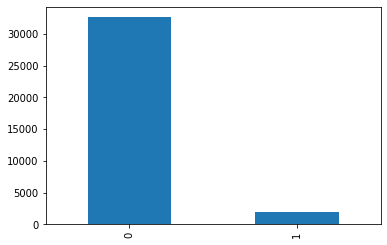

In [12]:
count = finalDf.READMISSION.value_counts()
count.plot.bar()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(finalDf.drop(['READMISSION'], axis=1), finalDf['READMISSION'],
                                                    test_size=0.2, random_state=30)

In [187]:
#The class is clearly imbalanced here
y_train.value_counts()

0    26081
1     1567
Name: READMISSION, dtype: int64

In [6]:
#To balance the class setting class_weight parameter as balanced
lr = LogisticRegression(C = 0.1, penalty = 'l2', random_state = 30,class_weight="balanced",max_iter=500)
lr.fit(X_train, y_train)
lrPredProbs_tr = lr.predict_proba(X_train)
lrPredProbs_ts = lr.predict_proba(X_test)
lrPred_tr = lr.predict(X_train)
lrPred_ts = lr.predict(X_test)
lrFpr_tr, lrTpr_tr, lrThresh_tr = roc_curve(y_train, lrPredProbs_tr[:,1])
lrFpr_ts, lrTpr_ts, lrThresh_ts = roc_curve(y_test, lrPredProbs_ts[:,1])

C:\Users\samsu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [7]:
print('Train Accuracy:%.3f'%accuracy_score(y_train, lrPred_tr))
print('Test Accuracy:%.3f'%accuracy_score(y_test, lrPred_ts))
print('Train Recall:%.3f'%recall_score(y_train, lrPred_tr))
print('Test Recall:%.3f'%recall_score(y_test, lrPred_ts))
print('Train Precision:%.3f'%precision_score(y_train, lrPred_tr))
print('Test Precision:%.3f'%precision_score(y_test, lrPred_ts))
print('Train AUC:%.3f'%roc_auc_score(y_train, lrPredProbs_tr[:,1]))
print('Test AUC:%.3f'%roc_auc_score(y_test, lrPredProbs_ts[:,1]))

Train Accuracy:0.830
Test Accuracy:0.816
Train Recall:0.884
Test Recall:0.750
Train Precision:0.234
Test Precision:0.191
Train AUC:0.931
Test AUC:0.844


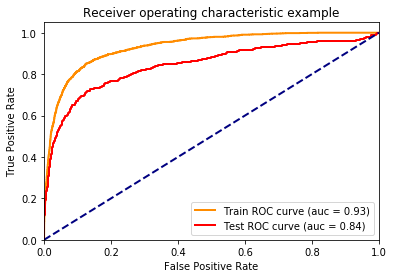

In [9]:
plt.figure()
plt.plot(lrFpr_tr, lrTpr_tr, color='darkorange',lw=2, label='Train ROC curve (auc = %0.2f)' %roc_auc_score(y_train, lrPredProbs_tr[:,1]))
plt.plot(lrFpr_ts, lrTpr_ts, color='red',lw=2, label='Test ROC curve (auc = %0.2f)' %roc_auc_score(y_test, lrPredProbs_ts[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [8]:
confusion_matrix(y_test, lrPred_ts)

array([[5359, 1181],
       [  93,  279]], dtype=int64)

In [59]:
#True positive (TP): Prediction is X should Readmit and X did, we want that
#True negative (TN): Prediction is X should not Readmit and X did not, we want that too
#False positive (FP): Prediction is X should Readmit and X did not, false alarm, bad
#False negative (FN): Prediction is X should not Readmit and X did, the worst

In [60]:
#Recall/Sensitivity = TP/(TP+FN)--Appropriate for minimizing false negatives
#Specificity = TN/(TN+FP)--Appropriate for minimizing false negatives
#Both should be balanced but we want FN to decrease with the cost of increase in FPs
#So after looking at the math we can have low specificity if FP inceases while achieving High Recall.
#I am tuning the model for better Recall.

In [61]:
from pprint import pprint
C=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1)
class_weight = ['balanced','none']

# Create the random grid
random_grid = {'C':C,'class_weight': class_weight}
pprint(random_grid)

{'C': (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1),
 'class_weight': ['balanced', 'none']}


In [62]:
#logistic = LogisticRegression(max_iter=4000,penalty='l2')
#lr_random = RandomizedSearchCV(estimator = logistic, param_distributions = random_grid,
#                               n_iter = 10,scoring='recall',cv= 3,verbose=2,random_state=30, n_jobs = -1)
#bestFit = lr_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 154.7min finished
C:\Users\samsu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [63]:
bestFit.best_params_

{'class_weight': 'balanced', 'C': 0.1}

In [10]:
#Running the model based on best paramters
lr1 = LogisticRegression(C=0.1,max_iter=4000,class_weight ='balanced',penalty='l2',random_state=30)
lr1.fit(X_train,y_train)
lr1PredProbs_tr = lr1.predict_proba(X_train)
lr1PredProbs_ts = lr1.predict_proba(X_test)
lr1Pred_tr = lr1.predict(X_train)
lr1Pred_ts = lr1.predict(X_test)
lr1Fpr_tr, lr1Tpr_tr, lr1Thresh_tr = roc_curve(y_train, lr1PredProbs_tr[:,1])
lr1Fpr_ts, lr1Tpr_ts, lr1Thresh_ts = roc_curve(y_test, lr1PredProbs_ts[:,1])

C:\Users\samsu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [11]:
print('Train Accuracy:%.3f'%accuracy_score(y_train, lr1Pred_tr))
print('Test Accuracy:%.3f'%accuracy_score(y_test, lr1Pred_ts))
print('Train Recall:%.3f'%recall_score(y_train, lr1Pred_tr))
print('Test Recall:%.3f'%recall_score(y_test, lr1Pred_ts))
print('Train Precision:%.3f'%precision_score(y_train, lr1Pred_tr))
print('Test Precision:%.3f'%precision_score(y_test, lr1Pred_ts))
print('Train AUC:%.3f'%roc_auc_score(y_train, lr1PredProbs_tr[:,1]))
print('Test AUC:%.3f'%roc_auc_score(y_test, lr1PredProbs_ts[:,1]))

Train Accuracy:0.937
Test Accuracy:0.901
Train Recall:0.985
Test Recall:0.546
Train Precision:0.471
Test Precision:0.282
Train AUC:0.986
Test AUC:0.753


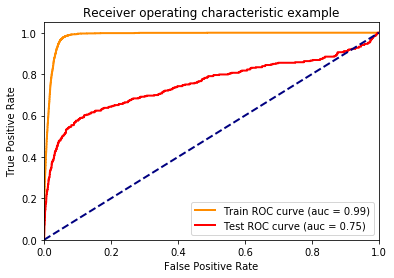

In [12]:
plt.figure()
plt.plot(lr1Fpr_tr, lr1Tpr_tr, color='darkorange',lw=2, label='Train ROC curve (auc = %0.2f)' %roc_auc_score(y_train, lr1PredProbs_tr[:,1]))
plt.plot(lr1Fpr_ts, lr1Tpr_ts, color='red',lw=2, label='Test ROC curve (auc = %0.2f)' %roc_auc_score(y_test, lr1PredProbs_ts[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [13]:
confusion_matrix(y_test, lr1Pred_ts)

array([[6023,  517],
       [ 169,  203]], dtype=int64)

In [14]:
rf = RandomForestClassifier(random_state = 30,class_weight='balanced')
rf.fit(X_train, y_train)
rfPredProbs_tr = rf.predict_proba(X_train)
rfPredProbs_ts = rf.predict_proba(X_test)
rfPred_tr = rf.predict(X_train)
rfPred_ts = rf.predict(X_test)
rfFpr_tr, rfTpr_tr, rfThresh_tr = roc_curve(y_train, rfPredProbs_tr[:,1])
rfFpr_ts, rfTpr_ts, rfThresh_ts = roc_curve(y_test, rfPredProbs_ts[:,1])

In [15]:
print('Train Accuracy:%.3f'%accuracy_score(y_train, rfPred_tr))
print('Test Accuracy:%.3f'%accuracy_score(y_test, rfPred_ts))
print('Train Recall:%.3f'%recall_score(y_train, rfPred_tr))
print('Test Recall:%.3f'%recall_score(y_test, rfPred_ts))
print('Train Precision:%.3f'%precision_score(y_train, rfPred_tr))
print('Test Precision:%.3f'%precision_score(y_test, rfPred_ts))
print('Train AUC:%.3f'%roc_auc_score(y_train, rfPredProbs_tr[:,1]))
print('Test AUC:%.3f'%roc_auc_score(y_test, rfPredProbs_ts[:,1]))

Train Accuracy:1.000
Test Accuracy:0.949
Train Recall:1.000
Test Recall:0.118
Train Precision:1.000
Test Precision:0.638
Train AUC:1.000
Test AUC:0.940


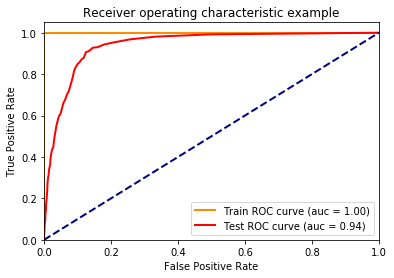

In [16]:
plt.figure()
plt.plot(rfFpr_tr, rfTpr_tr, color='darkorange',lw=2, label='Train ROC curve (auc = %0.2f)' %roc_auc_score(y_train, rfPredProbs_tr[:,1]))
plt.plot(rfFpr_ts, rfTpr_ts, color='red',lw=2, label='Test ROC curve (auc = %0.2f)' %roc_auc_score(y_test, rfPredProbs_ts[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [17]:
confusion_matrix(y_test, rfPred_ts)

array([[6515,   25],
       [ 328,   44]], dtype=int64)

In [65]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Balancing the output labels
class_weight = ['balanced','balanced_subsample']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight}
pprint(random_grid)

{'bootstrap': [True, False],
 'class_weight': ['balanced', 'balanced_subsample'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [66]:
#randomForest = RandomForestClassifier()
#rf_random = RandomizedSearchCV(estimator = randomForest, param_distributions = random_grid, 
#                               n_iter = 100,scoring='recall',cv= 3,verbose=2, random_state=30, n_jobs = -1)
#bestFitRf = rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 154.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 302.5min finished


In [67]:
bestFitRf.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': 'balanced_subsample',
 'bootstrap': True}

In [18]:
rf1 = RandomForestClassifier(n_estimators=800,min_samples_split=10,min_samples_leaf=4,max_features='sqrt',max_depth=10,
                             class_weight='balanced_subsample',bootstrap= True,n_jobs = -1,random_state = 30)
rf1.fit(X_train, y_train)
rf1PredProbs_tr = rf1.predict_proba(X_train)
rf1PredProbs_ts = rf1.predict_proba(X_test)
rf1Pred_tr = rf1.predict(X_train)
rf1Pred_ts = rf1.predict(X_test)
rf1Fpr_tr, rf1Tpr_tr, rf1Thresh_tr = roc_curve(y_train, rf1PredProbs_tr[:,1])
rf1Fpr_ts, rf1Tpr_ts, rf1Thresh_ts = roc_curve(y_test, rf1PredProbs_ts[:,1])

In [19]:
print('Train Accuracy:%.3f'%accuracy_score(y_train, rf1Pred_tr))
print('Test Accuracy:%.3f'%accuracy_score(y_test, rf1Pred_ts))
print('Train Recall:%.3f'%recall_score(y_train, rf1Pred_tr))
print('Test Recall:%.3f'%recall_score(y_test, rf1Pred_ts))
print('Train Precision:%.3f'%precision_score(y_train, rf1Pred_tr))
print('Test Precision:%.3f'%precision_score(y_test, rf1Pred_ts))
print('Train AUC:%.3f'%roc_auc_score(y_train, rf1PredProbs_tr[:,1]))
print('Test AUC:%.3f'%roc_auc_score(y_test, rf1PredProbs_ts[:,1]))

Train Accuracy:0.930
Test Accuracy:0.910
Train Recall:0.986
Test Recall:0.804
Train Precision:0.446
Test Precision:0.353
Train AUC:0.990
Test AUC:0.944


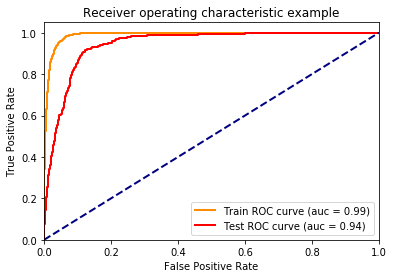

In [20]:
plt.figure()
plt.plot(rf1Fpr_tr, rf1Tpr_tr, color='darkorange',lw=2, label='Train ROC curve (auc = %0.2f)' %roc_auc_score(y_train, rf1PredProbs_tr[:,1]))
plt.plot(rf1Fpr_ts, rf1Tpr_ts, color='red',lw=2, label='Test ROC curve (auc = %0.2f)' %roc_auc_score(y_test, rf1PredProbs_ts[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [21]:
confusion_matrix(y_test, rf1Pred_ts)

array([[5992,  548],
       [  73,  299]], dtype=int64)

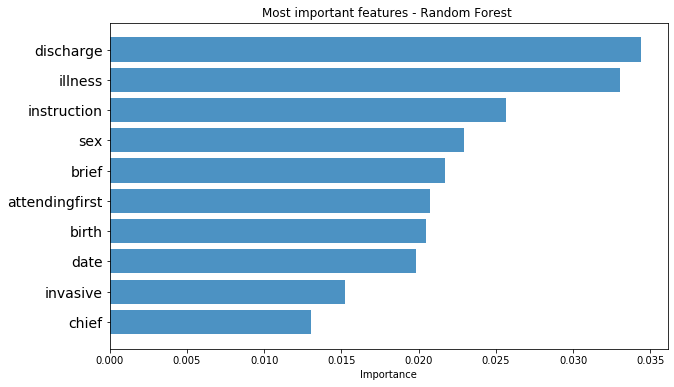

In [207]:
feature_names = X_train.columns
feature_imports = rf1.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

In [ ]:
#spanning over 2000 trees adding 100 at a time 
list_a = []
for n in range(100,2100,100):
    rf2 = RandomForestClassifier(n_estimators = n,n_jobs=-1)
    rf2.fit(X_train,y_train)
    probs = rf2.predict_proba(X_test)[:,1]
    a=roc_auc_score(y_test, probs)
    print(a)
    list_a.append(a)

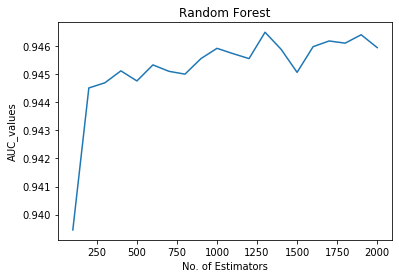

In [69]:
plt.plot(list(range(100,2100,100)),list_a)
plt.title('Random Forest')
plt.xlabel('No. of Estimators')
plt.ylabel('AUC_values')
plt.show()

In [96]:
cols = X_train.columns
rank = pd.DataFrame()
rank['columnNames'] = cols
rank['values'] = rf1.feature_importances_

In [ ]:
#Adding 100 predictors at a time
list_b = []
x = len(rank.index)+100
for i in range(100,x,100):
    c = list(rank[1:i]['columnNames'])
    rf2 = RandomForestClassifier(n_estimators=150, n_jobs=-1)
    rf2.fit(X_train[c],y_train)
    probs = rf2.predict_proba(X_test[c])[:,1]
    a=roc_auc_score(y_test, probs)
    #print(a)
    list_b.append(a)

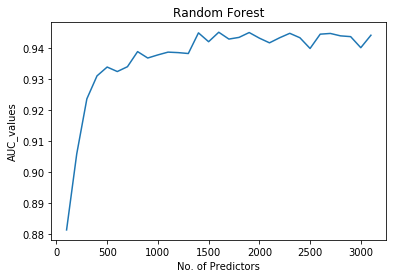

In [98]:
plt.plot(list(range(100,x,100)),list_b)
plt.title('Random Forest')
plt.xlabel('No. of Predictors')
plt.ylabel('AUC_values')
plt.show()

In [ ]:
#adding 100 attributes at a time with 100 observations
size = []
auc_rf = []
y = len(X_train)+1000
for i in range(100,x,100):
    for j in range(100, 1100, 100):
        s = int(j/1000.0*len(X_train.index))
        size.append(s)
        #print(s)
        c = list(rank[:i]['columnNames'])
        #print(c)
        rf2 = RandomForestClassifier(n_estimators=100,n_jobs=-1)
        rf2.fit(X_train[:s][c],y_train[:s])
        probs = rf2.predict_proba(X_test[c])[:,1]
        a=roc_auc_score(y_test, probs)
        #print(a)
        auc_rf.append(a)

In [100]:
b=[]
for i in range(100,x,100):
    for j in range(100, 1100, 100):
        c = list(rank[:i]['columnNames'])
        a = len(c)
        b.append(a)

In [101]:
print(len(b))
print(len(auc_rf))
print(len(size))

310
310
310


Text(0.5, 0, 'AUC_values')

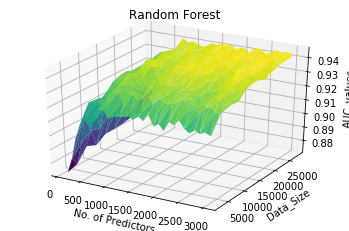

In [104]:
#X-axis represents the size of the attributes 100 at a time for 2700 rows .
#Y-axis represents the size of the data.
#Z-axis represents the AUC values.
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.plot_trisurf(b,size,auc_rf, cmap='viridis', edgecolor='none')
plt.title('Random Forest')
ax.set_xlabel('No. of Predictors')
ax.set_ylabel('Data_Size')
ax.set_zlabel('AUC_values')

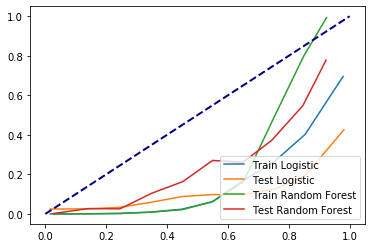

In [139]:
#Caliberation Curves before caliberating the Model
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
lr1Pred_tr_probs = lr1.predict_proba(X_train)[:,1]
lr1Pred_ts_probs = lr1.predict_proba(X_test)[:,1]
rf1Pred_tr_probs = rf1.predict_proba(X_train)[:,1]
rf1Pred_ts_probs = rf1.predict_proba(X_test)[:,1]

cur_lr_tr = calibration_curve(y_train,lr1Pred_tr_probs, n_bins=10)
cur_lr_ts = calibration_curve(y_test,lr1Pred_ts_probs, n_bins=10)
cur_rf_tr = calibration_curve(y_train,rf1Pred_tr_probs, n_bins=10)
cur_rf_ts = calibration_curve(y_test,rf1Pred_ts_probs, n_bins=10)

plt.plot(cur_lr_tr[1],cur_lr_tr[0],label='Train Logistic')
plt.plot(cur_lr_ts[1],cur_lr_ts[0],label='Test Logistic')
plt.plot(cur_rf_tr[1],cur_rf_tr[0],label='Train Random Forest')
plt.plot(cur_rf_ts[1],cur_rf_ts[0],label='Test Random Forest')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")

In [ ]:
#In calibration we try to improve our model such that the distribution and behavior of the probability predicted 
#is similar to the distribution and behavior of probability observed in training data.

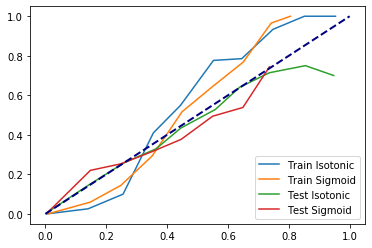

In [121]:
#Caliberating Random Forest
rf_iso = CalibratedClassifierCV(rf1, cv=5, method='isotonic')
rf_sig = CalibratedClassifierCV(rf1, cv=5, method='sigmoid')

rf_iso.fit(X_train, y_train)
rf_sig.fit(X_train, y_train)

probs_rf_tr_iso = rf_iso.predict_proba(X_train)[:,1]
probs_rf_ts_iso = rf_iso.predict_proba(X_test)[:,1]
probs_rf_tr_sig = rf_sig.predict_proba(X_train)[:,1]
probs_rf_ts_sig = rf_sig.predict_proba(X_test)[:,1]

cur_rf_tr_iso = calibration_curve(y_train,probs_rf_tr_iso, n_bins=10)
cur_rf_ts_iso = calibration_curve(y_test,probs_rf_ts_iso, n_bins=10)
cur_rf_tr_sig = calibration_curve(y_train,probs_rf_tr_sig, n_bins=10)
cur_rf_ts_sig = calibration_curve(y_test,probs_rf_ts_sig, n_bins=10)

plt.plot(cur_rf_tr_iso[1],cur_rf_tr_iso[0],label='Train Isotonic')
plt.plot(cur_rf_ts_iso[1],cur_rf_ts_iso[0],label='Test Isotonic')
plt.plot(cur_rf_tr_sig[1],cur_rf_tr_sig[0],label='Train Sigmoid')
plt.plot(cur_rf_ts_sig[1],cur_rf_ts_sig[0],label='Test Sigmoid')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")

(array([6009.,  245.,  182.,  146.,  122.,   87.,   78.,   43.,    0.,
           0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1 Patch objects>)

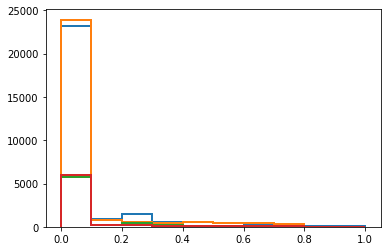

In [132]:
plt.hist(probs_rf_tr_iso, range=(0, 1), bins=10, histtype="step", lw=2)
plt.hist(probs_rf_tr_sig, range=(0, 1), bins=10, histtype="step", lw=2)
plt.hist(probs_rf_ts_iso, range=(0, 1), bins=10, histtype="step", lw=2)
plt.hist(probs_rf_ts_sig, range=(0, 1), bins=10, histtype="step", lw=2)

In [ ]:
#Caliberating Random Forest
lr_iso = CalibratedClassifierCV(lr1, cv=5, method='isotonic')
lr_sig = CalibratedClassifierCV(lr1, cv=5, method='sigmoid')

lr_iso.fit(X_train, y_train)
lr_sig.fit(X_train, y_train)

probs_lr_tr_iso = lr_iso.predict_proba(X_train)[:,1]
probs_lr_ts_iso = lr_iso.predict_proba(X_test)[:,1]
probs_lr_tr_sig = lr_sig.predict_proba(X_train)[:,1]
probs_lr_ts_sig = lr_sig.predict_proba(X_test)[:,1]

cur_lr_tr_iso = calibration_curve(y_train,probs_lr_tr_iso, n_bins=10)
cur_lr_ts_iso = calibration_curve(y_test,probs_lr_ts_iso, n_bins=10)
cur_lr_tr_sig = calibration_curve(y_train,probs_lr_tr_sig, n_bins=10)
cur_lr_ts_sig = calibration_curve(y_test,probs_lr_ts_sig, n_bins=10)

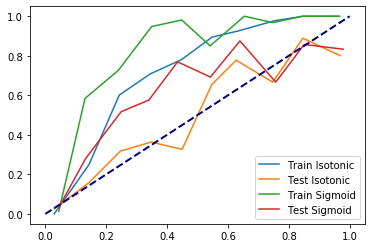

In [150]:
plt.plot(cur_lr_tr_iso[1],cur_lr_tr_iso[0],label='Train Isotonic')
plt.plot(cur_lr_ts_iso[1],cur_lr_ts_iso[0],label='Test Isotonic')
plt.plot(cur_lr_tr_sig[1],cur_lr_tr_sig[0],label='Train Sigmoid')
plt.plot(cur_lr_ts_sig[1],cur_lr_ts_sig[0],label='Test Sigmoid')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")

(array([6.505e+03, 2.600e+02, 5.800e+01, 3.300e+01, 1.300e+01, 1.300e+01,
        8.000e+00, 9.000e+00, 7.000e+00, 6.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1 Patch objects>)

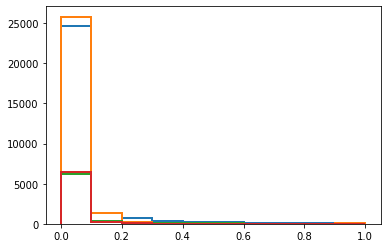

In [158]:
plt.hist(probs_lr_tr_iso, range=(0, 1), bins=10, histtype="step", lw=2)
plt.hist(probs_lr_tr_sig, range=(0, 1), bins=10, histtype="step", lw=2)
plt.hist(probs_lr_ts_iso, range=(0, 1), bins=10, histtype="step", lw=2)
plt.hist(probs_lr_ts_sig, range=(0, 1), bins=10, histtype="step", lw=2)

In [ ]:
#Neural Network

In [176]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers
import keras.backend as K

Using TensorFlow backend.


In [23]:
X_train.shape

(27648, 3018)

In [196]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(180, activation= 'relu', input_shape=(3018,)))
model.add(tf.keras.layers.Dense(110, activation= 'relu'))
model.add(tf.keras.layers.Dense(2, activation= 'softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train.values,y_train.values,epochs = 10)

Train on 27648 samples
Epoch 1/10
27648/27648 [==============================] - 9s 312us/sample - loss: 15.3233 - accuracy: 0.8859
Epoch 2/10
27648/27648 [==============================] - 5s 189us/sample - loss: 2.2022 - accuracy: 0.9091
Epoch 3/10
27648/27648 [==============================] - 8s 275us/sample - loss: 0.7729 - accuracy: 0.9256
Epoch 4/10
27648/27648 [==============================] - 5s 194us/sample - loss: 0.4292 - accuracy: 0.9351
Epoch 5/10
27648/27648 [==============================] - 7s 236us/sample - loss: 0.2510 - accuracy: 0.9435
Epoch 6/10
27648/27648 [==============================] - 6s 226us/sample - loss: 0.1612 - accuracy: 0.9507
Epoch 7/10
27648/27648 [==============================] - 6s 208us/sample - loss: 0.1528 - accuracy: 0.9519
Epoch 8/10
27648/27648 [==============================] - 7s 266us/sample - loss: 0.1473 - accuracy: 0.9525
Epoch 9/10
27648/27648 [==============================] - 6s 207us/sample - loss: 0.1422 - accuracy: 0.9538
Epoc

In [197]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 180)               543420    
_________________________________________________________________
dense_55 (Dense)             (None, 110)               19910     
_________________________________________________________________
dense_56 (Dense)             (None, 2)                 222       
Total params: 563,552
Trainable params: 563,552
Non-trainable params: 0
_________________________________________________________________


In [198]:
pred_tr = model.predict(X_train.values)
pred_ts = model.predict(X_test.values)

In [199]:
Fpr_tr, Tpr_tr, Thresh_tr = roc_curve(y_train, pred_tr[:,1])
Fpr_ts, Tpr_ts, Thresh_ts = roc_curve(y_test, pred_ts[:,1])
print('Train Accuracy:%.3f'%accuracy_score(y_train, pred_tr.argmax(1)))
print('Test Accuracy:%.3f'%accuracy_score(y_test, pred_ts.argmax(1)))
print('Train Recall:%.3f'%recall_score(y_train, pred_tr.argmax(1)))
print('Test Recall:%.3f'%recall_score(y_test, pred_ts.argmax(1)))
print('Train Precision:%.3f'%precision_score(y_train, pred_tr.argmax(1)))
print('Test Precision:%.3f'%precision_score(y_test, pred_ts.argmax(1)))
print('Train AUC:%.3f'%roc_auc_score(y_train, pred_tr[:,1]))
print('Test AUC:%.3f'%roc_auc_score(y_test, pred_ts[:,1]))

Train Accuracy:0.956
Test Accuracy:0.947
Train Recall:0.605
Test Recall:0.489
Train Precision:0.614
Test Precision:0.508
Train AUC:0.956
Test AUC:0.919


In [200]:
confusion_matrix(y_test, pred_ts.argmax(1))

array([[6364,  176],
       [ 190,  182]], dtype=int64)

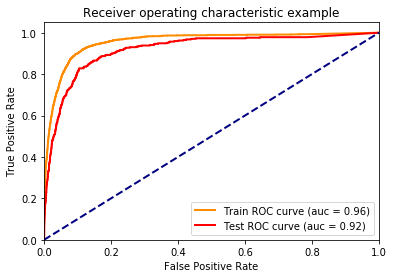

In [201]:
plt.figure()
plt.plot(Fpr_tr, Tpr_tr, color='darkorange',lw=2, label='Train ROC curve (auc = %0.2f)'%roc_auc_score(y_train, pred_tr[:,1]))
plt.plot(Fpr_ts, Tpr_ts, color='red',lw=2, label='Test ROC curve (auc = %0.2f)'%roc_auc_score(y_test, pred_ts[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [204]:
results = [['Logistic Regression','%.2f'%accuracy_score(y_test, lrPred_ts),'%.2f'%roc_auc_score(y_test, lrPredProbs_ts[:,1]),'%.2f'%recall_score(y_test, lrPred_ts),'%.2f'%precision_score(y_test, lrPred_ts),confusion_matrix(y_test, lrPred_ts)],
           ['Tuned Logistic Regression','%.2f'%accuracy_score(y_test, lr1Pred_ts),'%.2f'%roc_auc_score(y_test, lr1PredProbs_ts[:,1]),'%.2f'%recall_score(y_test, lr1Pred_ts),'%.2f'%precision_score(y_test, lr1Pred_ts),confusion_matrix(y_test, lr1Pred_ts)],
           ['Random Forest','%.2f'%accuracy_score(y_test, rfPred_ts),'%.2f'%roc_auc_score(y_test, rfPredProbs_ts[:,1]),'%.2f'%recall_score(y_test, rfPred_ts),'%.2f'%precision_score(y_test, rfPred_ts),confusion_matrix(y_test, rfPred_ts)],
           ['Tuned Random Forest','%.2f'%accuracy_score(y_test, rf1Pred_ts),'%.2f'%roc_auc_score(y_test, rf1PredProbs_ts[:,1]),'%.2f'%recall_score(y_test, rf1Pred_ts),'%.2f'%precision_score(y_test, rf1Pred_ts),confusion_matrix(y_test, rf1Pred_ts)],
           ['Neural Network','%.2f'%accuracy_score(y_test, pred_ts.argmax(1)),'%.2f'%roc_auc_score(y_test, pred_ts[:,1]),'%.2f'%recall_score(y_test, pred_ts.argmax(1)),'%.2f'%precision_score(y_test, pred_ts.argmax(1)),confusion_matrix(y_test, pred_ts.argmax(1))]]
resultsDf = pd.DataFrame(results,columns=['Model','Accuracy', 'AUC','Recall','Precision','Confusion Matrix'])

In [205]:
resultsDf

,Model,Accuracy,AUC,Recall,Precision,Confusion Matrix
0,Logistic Regression,0.82,0.84,0.75,0.19,"[[5359, 1181], [93, 279]]"
1,Tuned Logistic Regression,0.90,0.75,0.55,0.28,"[[6023, 517], [169, 203]]"
2,Random Forest,0.95,0.94,0.12,0.64,"[[6515, 25], [328, 44]]"
3,Tuned Random Forest,0.91,0.94,0.80,0.35,"[[5992, 548], [73, 299]]"
4,Neural Network,0.95,0.92,0.49,0.51,"[[6364, 176], [190, 182]]"
